In [1]:

# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI
    
    POFD = fp/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    print('{} {} {} {}'.format(CSI, POFD, AUC, freq))
    metric = 0.2*CSI_metric + 0.8*freq_metric


    return metric

2022-08-22 20:27:09.159367: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# ========== training/validation split ========== #

filename_aug = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_aug/*.npy"))
filename_full = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*.npy"))


In [9]:
cut_train_aug = 50000
cut_train_full = 600000

filename_train_aug = filename_aug[:cut_train_aug]
filename_train_full = filename_full[:cut_train_full]


In [63]:
factor = 8

L_valid_aug = int(50*factor)
L_valid_full = int(3000*factor)

filename_valid_aug = filename_aug[cut_train_aug:]
filename_valid_full = filename_full[cut_train_full:]

shuffle(filename_valid_aug)
shuffle(filename_valid_full)

filename_valid_aug = filename_aug[-L_valid_aug:]
filename_valid_full = filename_full[-L_valid_full:]

# ========== Validation set ========== #

ind_pick_from_batch = [1, 2, 5, 10, 11, 12, 13, 14, 15, 17]

L_vars = len(ind_pick_from_batch)

grid_shape = (128, 128)

L_valid = L_valid_aug+L_valid_full

VALID_input = np.empty((L_valid,)+grid_shape+(L_vars,))
VALID_target = np.empty(L_valid)

for i, filename in enumerate(filename_valid_aug+filename_valid_full):
    data = np.load(filename)
    
    for c, v in enumerate(ind_pick_from_batch):
    
        VALID_input[i, ..., c] = data[..., v]
        
    if 'pos' in filename:
        VALID_target[i] = True
    elif 'neg' in filename:
        VALID_target[i] = False
    else:
        aergheagtha

In [12]:
# ========== Model ========== #

# ---------- Layers ---------- #

IN = tf.keras.Input((128, 128, 10))

X = IN

X = k_layers.CONV_stack(X, 32, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(32, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 64, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(64, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 128, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(128, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 256, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(256, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

X = k_layers.CONV_stack(X, 512, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack5')
X = tf.keras.layers.Conv2D(512, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv5')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)

OUT = D

model = keras.models.Model(inputs=[IN,], outputs=[OUT,])

W_new = model.get_weights()

# ---------- Weights ---------- #

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'BIG10'

model_name = '{}_tornado_tune'.format(key)
model_path = temp_dir+model_name
model_path_backup = temp_dir+model_name+'_backup'

#W_new = k_utils.dummy_loader(model_path)

#W_old = k_utils.dummy_loader(temp_dir+'VGG_X_pp20_tune2')
W_new = k_utils.dummy_loader(temp_dir+'BIG10_tornado')
#W_new = k_utils.dummy_loader(model_path)

# for l in range(len(W_old)):
#     if W_old[l].shape == W_new[l].shape:
#         W_new[l] = W_old[l]

# ---------- Compile ---------- #

model.set_weights(W_new)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-5))



2022-08-22 20:39:38.495419: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-22 20:39:38.524012: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-22 20:39:38.674124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:62:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-22 20:39:38.674219: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-22 20:39:38.805115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-22 20:39:38.805190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [13]:
# ========== Initial record ========== #

Y_pred = model.predict([VALID_input,])
record = verif_metric(VALID_target, Y_pred)
print('Initial record {}'.format(record))

# ========== Training hyper parameters ========== #

tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100
batch_size_half = 50

valid_size = 1

X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

# ========== Training loop ========== #

L_full = len(filename_train_full)
L_aug = len(filename_train_aug)

for i in range(epochs):
    
    if i <= 10:
        batch_size_full = 70
    if i > 10 and i <= 35:
        batch_size_full = 85
    if i > 35:
        batch_size_full = 95
    
    batch_size_aug = batch_size - batch_size_full
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_full = du.shuffle_ind(L_full)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_full = []
        for ind_temp in ind_full[:batch_size_full]:
            file_pick_full.append(filename_train_full[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:batch_size_aug]:
            file_pick_aug.append(filename_train_aug[ind_temp])
        
        file_pick = file_pick_full + file_pick_aug
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            
            for c, v in enumerate(ind_pick_from_batch):
                
                X_batch[k, ..., c] = data[..., v]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input,])
    record_temp = verif_metric(VALID_target, Y_pred, thres=0.7)
    
    if i % 10 == 0:
        model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

2022-08-22 20:39:52.956735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-22 20:39:52.961891: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-08-22 20:39:54.306905: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-22 20:39:54.788027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


0.23873873873873874 0.019352686019352687 0.8719859796903822 1.5943396226415094
Initial record 0.6277239503654598
0.2864583333333333 0.01434768101434768 0.8824358950145114 1.330188679245283


2022-08-22 20:45:03.308422: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune_backup/assets
Validation loss improved from 0.6277239503654598 to 0.4068592767295598
save to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune/assets
--- 310.3586049079895 seconds ---
0.3271604938271605 0.009342676009342675 0.8954851077492587 1.028301886792453
Validation loss improved from 0.4068592767295598 to 0.15720941066853025
save to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune/assets
--- 252.381334066391 seconds ---
0.33505154639175255 0.014681348014681348 0.9040628678993459 1.4433962264150944
Validation loss 0.487706671853725 NOT improved
0.33974358974358976 0.008341675008341674 0.9064646407413702 0.9716981132075472
Validation loss improved from 0.15720941066853025 to 0.1546927914852443
save to: /glade

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x2b6673067a60>
Traceback (most recent call last):
  File "/glade/work/ksha/anaconda3/lib/python3.9/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 
Exception ignored in: <function ScopedTFGraph.__del__ at 0x2b666ed93310>
Traceback (most recent call last):
  File "/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [64]:
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'BIG10'

model_name = '{}_tornado_tune3'.format(key)
model_path = temp_dir+model_name

W_new = k_utils.dummy_loader(model_path)

model.set_weights(W_new)

In [65]:
# Y_pred = model.predict([VALID_input,])
# record_temp = verif_metric(VALID_target, Y_pred, thres=0.7)

In [66]:
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'BIG10'

model_name = '{}_tornado_tune4'.format(key)
model_path = temp_dir+model_name

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-6))

In [67]:
# ========== Initial record ========== #

Y_pred = model.predict([VALID_input,])
record = verif_metric(VALID_target, Y_pred, thres=0.7)
print('Initial record {}'.format(record))

0.17687074829931973 0.01906152241918665 0.9026405937557505 1.4423529411764706
Initial record 0.5185082032813126


In [ ]:

# ========== Training hyper parameters ========== #

tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100
batch_size_half = 50

valid_size = 1

X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

# ========== Training loop ========== #

L_full = len(filename_train_full)
L_aug = len(filename_train_aug)

for i in range(epochs):
    
    if i <= 10:
        batch_size_full = 70
    if i > 10 and i <= 35:
        batch_size_full = 85
    if i > 35:
        batch_size_full = 95
    
    batch_size_aug = batch_size - batch_size_full
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_full = du.shuffle_ind(L_full)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_full = []
        for ind_temp in ind_full[:batch_size_full]:
            file_pick_full.append(filename_train_full[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:batch_size_aug]:
            file_pick_aug.append(filename_train_aug[ind_temp])
        
        file_pick = file_pick_full + file_pick_aug
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            
            for c, v in enumerate(ind_pick_from_batch):
                
                X_batch[k, ..., c] = data[..., v]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input,])
    record_temp = verif_metric(VALID_target, Y_pred, thres=0.7)
    
    if i % 10 == 0:
        model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.17587373167981962 0.01927007299270073 0.9025079065202725 1.4541176470588235
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune_backup/assets
Validation loss 0.528119371311095 NOT improved
0.17567567567567569 0.019311783107403547 0.9016580997362447 1.4564705882352942
Validation loss 0.5300413354531003 NOT improved
0.17848970251716248 0.01872784150156413 0.9013394835306385 1.423529411764706
Validation loss improved from 0.5185082032813126 to 0.5031255889083323
save to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune4/assets
--- 558.9445395469666 seconds ---
0.1791569086651054 0.01789363920750782 0.9019445255474452 1.3694117647058823
Validation loss improved from 0.5031255889083323 to 0.4596980300316848
save to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/BIG10_tornado_tune4/

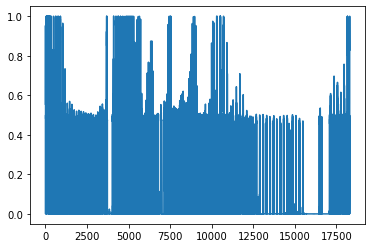

In [62]:
plt.plot(Y_pred)